# Embedding Ender's Game

In this notebook I will upload some books from the Ender's game universe, process them using *nltk*, and embed the words in the corpus using *word2vec*.

This is inspired by [this video](https://youtu.be/pY9EwZ02sXU) and implemented using [this source code](https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE).

**Thank you Siraj Raval!**

In [1]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

## Some dependencies

In [2]:
#encoding. word encodig
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system , like reading file
import os
#pretty print, human readable
import pprint
#regular expressions
import re
import tensorflow as tf

In [3]:
#natural language toolkit
import nltk
#dimensionality reduction
import sklearn.manifold
from bhtsne import tsne
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns
#word 2 vec
from gensim.models import word2vec as w2v

C:\Users\Rey\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Preprocess using *nltk*

In [6]:
#stopwords like the at a an, unnecesasry
#tokenization into sentences, punkt 
#http://www.nltk.org/
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#initialize rawunicode , all text goes here
corpus_raw = u""
with codecs.open('Ender.txt', "r", "utf-8") as book_file:
        corpus_raw += book_file.read()

In [8]:
corpus_raw[0:10]

" ENDER'S G"

In [9]:
#tokenizastion! saved the trained model here
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [11]:
raw_sentences[0:10]

[' ENDER\'S GAME\r\n by Orson Scott Card\r\n Chapter 1 -- Third\r\n\r\n "I\'ve watched through his eyes, I\'ve listened through his ears, and tell you he\'s the one.',
 'Or at least as close as we\'re going to get."',
 '"That\'s what you said about the brother."',
 '"The brother tested out impossible.',
 'For other reasons.',
 'Nothing to do with his ability."',
 '"Same with the sister.',
 'And there are doubts about him.',
 "He's too malleable.",
 'Too willing\r\nto submerge himself in someone else\'s will."']

In [12]:
#convert into list of words
#remove unecessary characters, split into words, no hyhens and shit
#split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#for each sentece, sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
sentences[0:10]

[['ENDER',
  'S',
  'GAME',
  'by',
  'Orson',
  'Scott',
  'Card',
  'Chapter',
  'Third',
  'I',
  've',
  'watched',
  'through',
  'his',
  'eyes',
  'I',
  've',
  'listened',
  'through',
  'his',
  'ears',
  'and',
  'tell',
  'you',
  'he',
  's',
  'the',
  'one'],
 ['Or', 'at', 'least', 'as', 'close', 'as', 'we', 're', 'going', 'to', 'get'],
 ['That', 's', 'what', 'you', 'said', 'about', 'the', 'brother'],
 ['The', 'brother', 'tested', 'out', 'impossible'],
 ['For', 'other', 'reasons'],
 ['Nothing', 'to', 'do', 'with', 'his', 'ability'],
 ['Same', 'with', 'the', 'sister'],
 ['And', 'there', 'are', 'doubts', 'about', 'him'],
 ['He', 's', 'too', 'malleable'],
 ['Too',
  'willing',
  'to',
  'submerge',
  'himself',
  'in',
  'someone',
  'else',
  's',
  'will']]

In [15]:
#print an example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Nothing to do with his ability."
['Nothing', 'to', 'do', 'with', 'his', 'ability']


In [16]:
#count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 503,902 tokens


## Build our model

In [17]:
#step 2 build our model, another one is Glove
#define hyperparameters

# Dimensionality of the resulting word vectors.
#more dimensions mean more traiig them, but more generalized
num_features = 300

#
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [18]:
ender2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [19]:
ender2vec.build_vocab(sentences)

2017-07-11 10:01:47,596 : INFO : collecting all words and their counts
2017-07-11 10:01:47,599 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-07-11 10:01:47,625 : INFO : PROGRESS: at sentence #10000, processed 111908 words, keeping 8059 word types
2017-07-11 10:01:47,657 : INFO : PROGRESS: at sentence #20000, processed 228097 words, keeping 11485 word types
2017-07-11 10:01:47,691 : INFO : PROGRESS: at sentence #30000, processed 353550 words, keeping 14782 word types
2017-07-11 10:01:47,722 : INFO : PROGRESS: at sentence #40000, processed 478152 words, keeping 17718 word types
2017-07-11 10:01:47,729 : INFO : collected 18299 word types from a corpus of 503902 raw words and 42110 sentences
2017-07-11 10:01:47,731 : INFO : Loading a fresh vocabulary
2017-07-11 10:01:47,755 : INFO : min_count=3 retains 7725 unique words (42% of original 18299, drops 10574)
2017-07-11 10:01:47,757 : INFO : min_count=3 leaves 490596 word corpus (97% of original 503902, drops

In [20]:
print("Word2Vec vocabulary length:", len(ender2vec.wv.vocab))

Word2Vec vocabulary length: 7725


In [21]:
#train model on sentneces
ender2vec.train(sentences, 
        total_examples=ender2vec.corpus_count, epochs=5)

2017-07-11 10:01:47,948 : INFO : training model with 4 workers on 7725 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-07-11 10:01:48,978 : INFO : PROGRESS: at 16.01% examples, 288516 words/s, in_qsize 7, out_qsize 0
2017-07-11 10:01:50,011 : INFO : PROGRESS: at 32.42% examples, 289600 words/s, in_qsize 7, out_qsize 0
2017-07-11 10:01:51,039 : INFO : PROGRESS: at 49.57% examples, 295089 words/s, in_qsize 7, out_qsize 0
2017-07-11 10:01:52,048 : INFO : PROGRESS: at 65.70% examples, 295642 words/s, in_qsize 7, out_qsize 0
2017-07-11 10:01:53,076 : INFO : PROGRESS: at 82.37% examples, 296364 words/s, in_qsize 7, out_qsize 0
2017-07-11 10:01:54,080 : INFO : PROGRESS: at 97.97% examples, 295789 words/s, in_qsize 6, out_qsize 0
2017-07-11 10:01:54,122 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-07-11 10:01:54,138 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-07-11 10:01:54,178 : INFO : worker thread fini

1847327

## That's it! we embedded our word vectors!

### Now Let's play...

In [22]:
#save model
#if not os.path.exists("trained"):
#    os.makedirs("trained")

In [23]:
#ender2vec.save(os.path.join("trained", "ender2vec.w2v"))

In [24]:
#load model
#ender2vec = w2v.Word2Vec.load(os.path.join("trained", "ender2vec.w2v"))

### Perform dimentionality reduction using *tsne* 

In [25]:
#put it all into a giant matrix
all_word_vectors_matrix = ender2vec.wv.syn0
#train t sne
all_word_vectors_matrix_2d = tsne(all_word_vectors_matrix.astype(
        'float64'))



#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
#tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [26]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[ender2vec.wv.vocab[word].index])
            for word in ender2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [27]:
points.head(10)

,word,x,y
0,fantasy,11.343205,16.279901
1,hack,6.022543,-6.860435
2,especially,3.711407,9.991717
3,fair,20.817693,18.568522
4,bitterly,-13.945222,18.824310
5,borders,-19.640680,-4.177245
6,installation,14.196790,-6.077750
7,classified,12.730750,-25.769162
8,honors,-6.194168,-1.793721
9,reset,-5.340360,-19.989232


In [28]:
#plot
sns.set_context("poster")

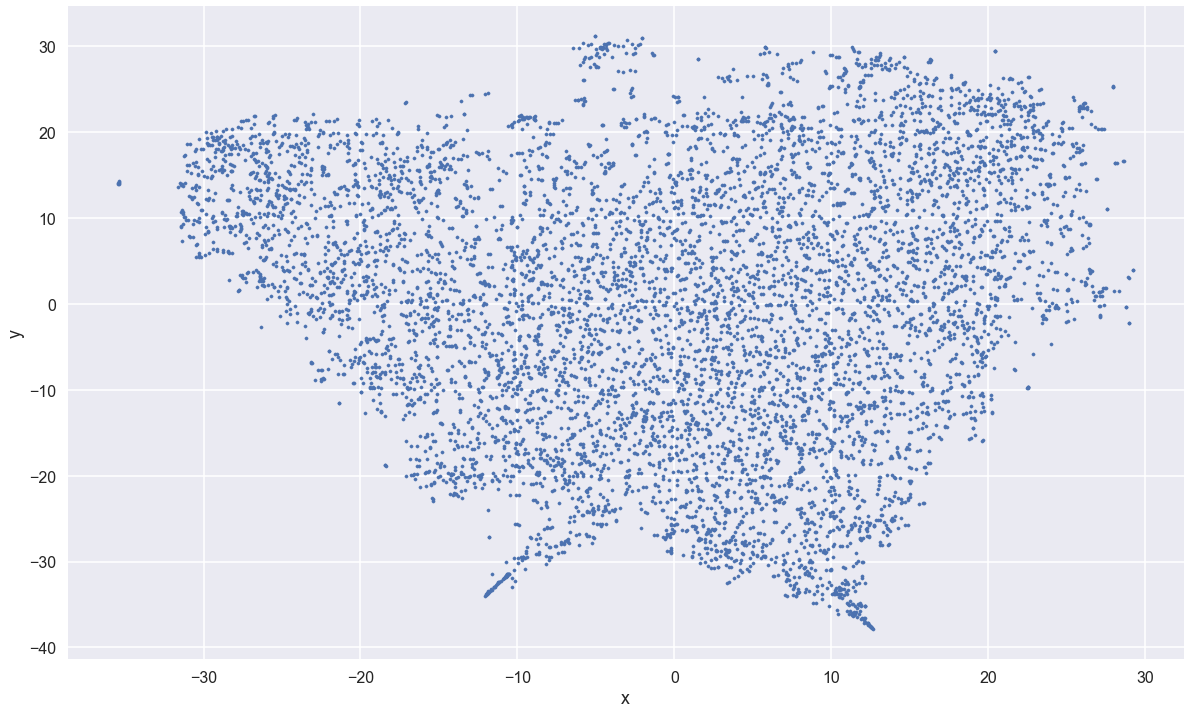

In [29]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [30]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(8, 6))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

### Let's have a closer look at some interesting regions

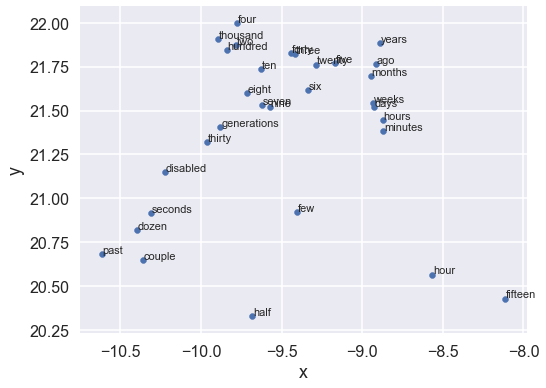

In [33]:
plot_region(x_bounds=(-11.0, -8.0), y_bounds=(20.0, 22.0))

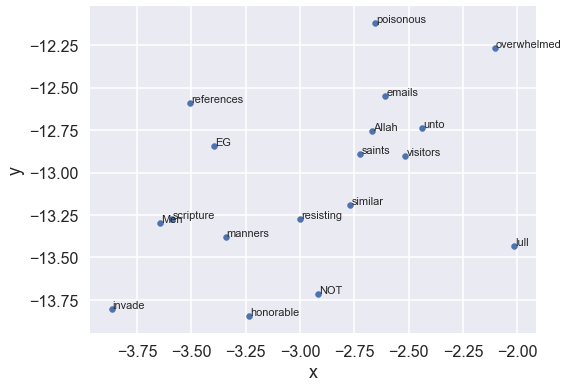

In [35]:
plot_region(x_bounds=(-4.0,-2.0), y_bounds=(-14.0, -12.0))

### Let's try some synonyms

In [36]:
ender2vec.most_similar("Bean")

2017-07-11 10:06:59,577 : INFO : precomputing L2-norms of word weight vectors


[('Abra', 0.856671929359436),
 ('Dimak', 0.8502662181854248),
 ('Suriyawong', 0.8372159600257874),
 ('Virlomi', 0.8344117403030396),
 ('Alai', 0.8295029401779175),
 ('Petra', 0.8274972438812256),
 ('Po', 0.8150452375411987),
 ('Sayagi', 0.8135854601860046),
 ('Shen', 0.8131986856460571),
 ('Valentine', 0.8016278147697449)]

In [37]:
ender2vec.most_similar("battleroom")

[('simulator', 0.9250400066375732),
 ('corridors', 0.9180313348770142),
 ('middle', 0.917226254940033),
 ('station', 0.9154456853866577),
 ('barracks', 0.9098254442214966),
 ('center', 0.9065952301025391),
 ('bathroom', 0.9010128974914551),
 ('ducts', 0.8926106691360474),
 ('lights', 0.8914101123809814),
 ('building', 0.8913547992706299)]

In [38]:
ender2vec.most_similar("Buggers")

[('buggers', 0.93250572681427),
 ('Formics', 0.8790562152862549),
 ('humans', 0.8626824021339417),
 ('Bugger', 0.8618757724761963),
 ('First', 0.8585050106048584),
 ('rules', 0.8479388356208801),
 ('universe', 0.845893144607544),
 ('fighting', 0.836578369140625),
 ('teachers', 0.8339317440986633),
 ('Russians', 0.8324226140975952)]

### Let's look at some word associations

In [39]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = ender2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [40]:
nearest_similarity_cosmul("Ender", "Valentine", "Bean")
# interesting: http://enderverse.wikia.com/wiki/Suriyawong

Ender is related to Valentine, as Suriyawong is related to Bean


'Suriyawong'

In [41]:
nearest_similarity_cosmul("Peter", "Valentine", "Locke")
# amazing!!

Peter is related to Valentine, as Demosthenes is related to Locke


'Demosthenes'

In [42]:
nearest_similarity_cosmul("run", "slow", "fight")

run is related to slow, as survive is related to fight


'survive'

In [43]:
nearest_similarity_cosmul("love", "hate", "formics")

love is related to hate, as officers is related to formics


'officers'